In [174]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [175]:
from modal_piano import Resonator

r = Resonator(f_k=440, tau=0.2, A=1.0)
r.display_transfer_function()
r.estimate_resonant_frequency()
r.as_faust_tf21t()

transfer function:


<IPython.core.display.Math object>

'(fi.tf21t(0.0, 1.420435863872817e-06, 0.0, -1.9958450297503125, 0.9997732683378947))'

In [276]:
resonators = []
for i in range(10):
    # For square wave, use only odd harmonics with amplitude 1/(harmonic number)
    harmonic = 2 * i + 1  # 1, 3, 5, 7, 9, 11, 13, 15, 17, 19
    frequency = 440 * harmonic
    amplitude = 1.0 / harmonic  # Amplitude decreases with harmonic number
    resonator = Resonator(f_k=frequency, tau=0.2, A=amplitude)
    resonators.append(resonator)


In [277]:
from audio_utils import get_stereo_impulse_response

plate_left, plate_right = get_stereo_impulse_response(
    **{
        "start_seconds": 0.000,
        "length_seconds": 3.0,
        "fade_in_seconds": 0.000,
        "fade_out_seconds": 3.0,
        "url": "https://oramics.github.io/sampled/IR/EMT140-Plate/samples/emt_140_dark_1.wav",
        # "dry_wet_balance": 1.0,
    }
)

# pad
from audio_utils import add_silence, impulse

# plate_left = add_silence(plate_left, 0.25, before=True), 1, before=False)
IMPULSE = impulse(1.0, 44100)

/Users/briancruz/repos/research/music_299_2025sp/audio_utils.py:25: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _sr, plate = wavfile.read(download_url(url))


In [278]:
import sympy as sy

m_h = sy.Symbol("m_h")
f_s = sy.Symbol("f_s")

values = {m_h: 0.01, f_s: 44100.0}

<>:20: SyntaxWarning: invalid escape sequence '\('
<>:20: SyntaxWarning: invalid escape sequence '\('
/var/folders/zk/5c2c39w140d2jm1q_p1lzdr00000gn/T/ipykernel_26731/983597925.py:20: SyntaxWarning: invalid escape sequence '\('
  template = """
/Users/briancruz/repos/research/music_299_2025sp/.venv/lib/python3.12/site-packages/setuptools/config/expand.py:128: SetuptoolsWarning: File '/Users/briancruz/repos/research/music_299_2025sp/requirements-test.txt' cannot be found
  for path in _filter_existing_files(_filepaths)
.venv/lib/python3.12/site-packages/FAUSTPy/__pycache__/_cffi__xa4062a9fx8f04052f.c:1145:3: warning: code will never be executed [-Wunreachable-code]
 1145 |   _cffi_check__MetaGlue(0);
      |   ^~~~~~~~~~~~~~~~~~~~~
.venv/lib/python3.12/site-packages/FAUSTPy/__pycache__/_cffi__xa4062a9fx8f04052f.c:1214:3: warning: code will never be executed [-Wunreachable-code]
 1214 |   _cffi_check__UIGlue(0);
      |   ^~~~~~~~~~~~~~~~~~~
.venv/lib/python3.12/site-packages/FAUSTPy/__p

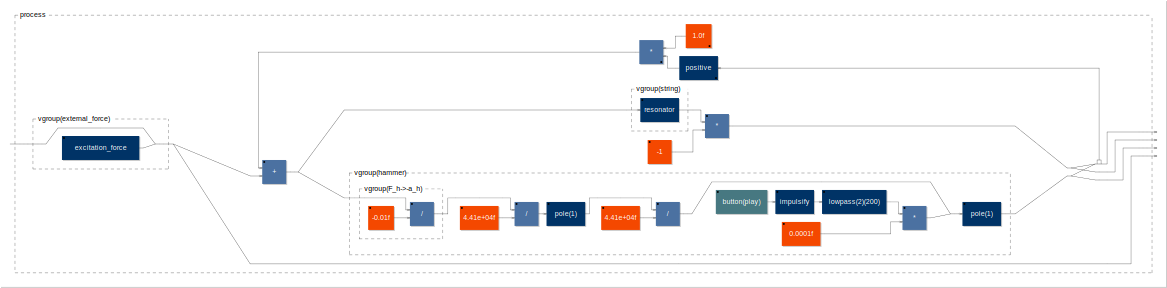

Listing b_ and p_ parameters:
b_external_force
b_hammer
(4, 48510)


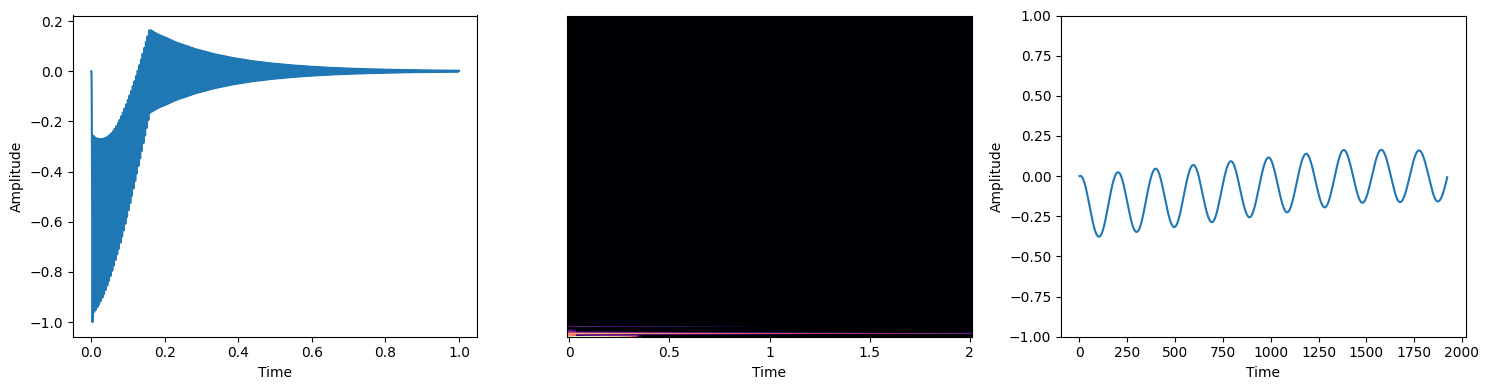

In [279]:
import jinja2
import numpy as np

from audio_utils import AudioClip
from modal_piano import Resonator
from pyfaust import FaustProcessor

# Create a list of 10 resonators for harmonics of 440 Hz (square wave has odd harmonics)
resonators = [
    Resonator(
        f_k=220 * harmonic * np.sqrt(1 + 0.03 * harmonic),
        tau=0.2,
        A=10 * 1.0 / harmonic**2,
    )
    for harmonic in [2 * i + 1 for i in range(20)]
]


# Generate Faust code using Jinja template
template = """
import("stdfaust.lib");

resonator = _ <:({% for res in resonators %}
    // Resonator {{ loop.index }}: {{ res.estimate_resonant_frequency() }} Hz
    {{ res.as_faust_tf21t() }}
    {% if not loop.last %},{% endif %}
{% endfor %}) :> _;

positive = \(x).(x * (x > 0.0));

excitation_force = (
    button("play")
    : ba.impulsify
    <: (fi.lowpass(2, 5000), (fi.lowpass(2, 2000) : de.delay(100,10)),  (fi.lowpass(2, 1000) : de.delay(200,20)))
    :> *(10)
);


// integrator
v_to_y = ((+ : + (0.0) )~ +(1));

// Modal resonator bank for parallel processing
process = 
_
: vgroup("external_force", _ <: _, excitation_force :> _) // Play button
<: ((
    +
    : (_ <:
        // The string simulation: Force to string position
        vgroup("string", resonator) * -1, // -y_s (string position * -1)
        // The hammer simulation: Force to hammer position
        vgroup(
            "hammer",
                //mem
                vgroup("F_h->-a_h", /({{ -m_h }})) // a_h (hammer acceleration)
                //: -(5) // gravity
                : /({{ f_s }})
                : fi.pole(1) // v_h (hammer velocity)
                : /({{ f_s }})
                : (_ <: _, (button("play"): ba.impulsify : fi.lowpass(2, 200)) * 0.0001 :> _)
                : fi.pole(1)
                // : ((+ : \(x).(x * (x > -0.0001)) )~ +(1)) // y_h (hammer position)
                // : ((+ : \(x).(x * (x > -0.0001)) )~ +(1)) // y_h (hammer position)
        ) 
    :> (
        _, _
        : route(2, 3, 1, 1, 2, 1, 1, 2, 2, 3)
        :
            (_), // Output0 : y_h - y_s (hammer position - string position)
            (_), // Output1 : -y_s (string position * -1)
            (_) // Output2 : y_h (hammer position)
        )
    )
) ~ (
    positive // F(\delta Y)
    * 1.0 // remove feedback for now
    )), _
;
"""


env = jinja2.Environment()
template_obj = env.from_string(template)
code = template_obj.render(
    resonators=resonators, **{str(k): v for k, v in values.items()}
)

with FaustProcessor(code) as fp:
    fp.show_signal_graph()

    # fp.dsp.dsp.b_external_force.p_play.zone = 1
    fp.dsp.dsp.b_my_faust.b_hammer.p_play.zone = 1

    print("Listing b_ and p_ parameters:")
    for item in dir(fp.dsp.dsp.b_my_faust):
        if item.startswith("p_") or item.startswith("b_"):
            print(item)
            # print(getattr(fp.dsp.dsp, item))

    # out = fp.compute(plate_left.astype(np.float32))
    out = fp.compute(add_silence(IMPULSE * 0.00, 0.1, before=True).astype(np.float32))

    print(out.samples.shape)
    out_fb = out.samples[1]
    # out_fb = convolve(out_fb, plate_left, mode="full")
    # out_fb = out_fb / np.max(np.abs(out_fb))

    AudioClip(out_fb).play(normalize=True)


In [280]:
print(code)


import("stdfaust.lib");

resonator = _ <:(
    // Resonator 1: 223.406982421875 Hz
    (fi.tf21t(0.0, 7.211431655906175e-06, 0.0, -1.998761491351029, 0.9997732683378947))
    ,

    // Resonator 2: 689.062500000000 Hz
    (fi.tf21t(0.0, 2.4692795671533904e-06, 0.0, -1.9901438640714935, 0.9997732683378947))
    ,

    // Resonator 3: 1180.28869628906 Hz
    (fi.tf21t(0.0, 1.517080278388511e-06, 0.0, -1.971596303598369, 0.9997732683378947))
    ,

    // Resonator 4: 1694.39392089844 Hz
    (fi.tf21t(0.0, 1.1059771441826076e-06, 0.0, -1.9418102491543776, 0.9997732683378947))
    ,

    // Resonator 5: 2231.37817382813 Hz
    (fi.tf21t(0.0, 8.749738631410501e-07, 0.0, -1.8995642998996392, 0.9997732683378947))
    ,

    // Resonator 6: 2791.24145507813 Hz
    (fi.tf21t(0.0, 7.256109116862886e-07, 0.0, -1.8437512460546468, 0.9997732683378947))
    ,

    // Resonator 7: 3371.29211425781 Hz
    (fi.tf21t(0.0, 6.200177548936735e-07, 0.0, -1.7734072263431568, 0.9997732683378947))
    ,

    

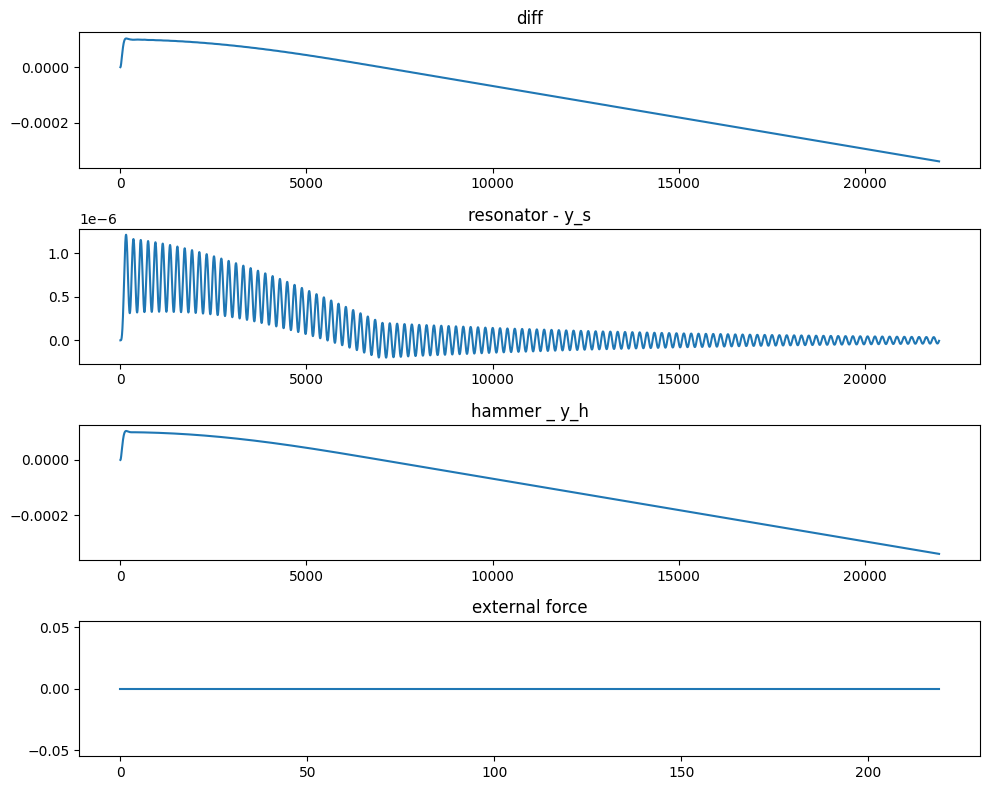

In [281]:
import matplotlib.pyplot as plt

# Make three graphs out.samples[0], out.samples[1], out.samples[2]
fig, axs = plt.subplots(4, 1, figsize=(10, 8))

axs[0].plot(out.samples[0, :22000])
axs[0].set_title("diff")

axs[1].plot(out.samples[1, :22000] * -1)
axs[1].set_title("resonator - y_s")

axs[2].plot(out.samples[2, :22000])
axs[2].set_title("hammer _ y_h")

axs[3].plot(out.samples[3, :220])
axs[3].set_title("external force")

plt.tight_layout()
plt.show()

<>:20: SyntaxWarning: invalid escape sequence '\('
<>:20: SyntaxWarning: invalid escape sequence '\('
/var/folders/zk/5c2c39w140d2jm1q_p1lzdr00000gn/T/ipykernel_26731/181113613.py:20: SyntaxWarning: invalid escape sequence '\('
  template = """
/Users/briancruz/repos/research/music_299_2025sp/.venv/lib/python3.12/site-packages/cffi/vengine_cpy.py:192: UserWarning: reimporting '_cffi__x1ac8de1cx29acc6aa' might overwrite older definitions
  warnings.warn("reimporting %r might overwrite older definitions"


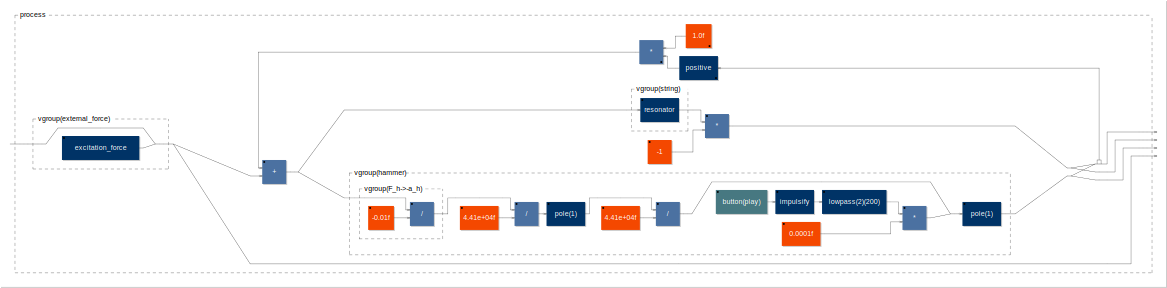

Listing b_ and p_ parameters:
b_external_force
b_hammer
(4, 48510)


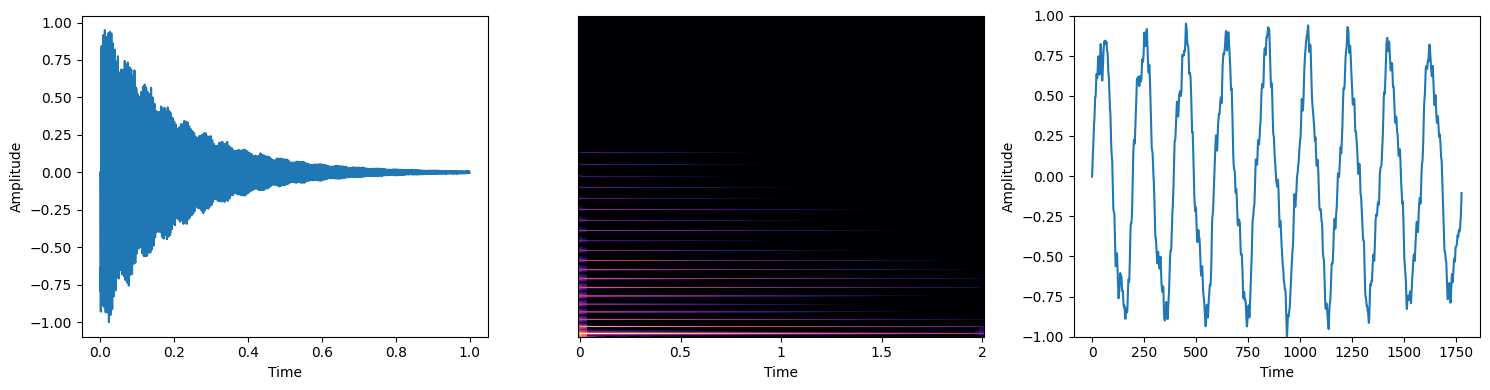

In [282]:
import jinja2
import numpy as np

from audio_utils import AudioClip
from modal_piano import Resonator
from pyfaust import FaustProcessor

# Create a list of 10 resonators for harmonics of 440 Hz (square wave has odd harmonics)
resonators = [
    Resonator(
        f_k=220 * harmonic * np.sqrt(1 + 0.03 * harmonic),
        tau=0.2,
        A=10 * 1.0 / harmonic,
    )
    for harmonic in [2 * i + 1 for i in range(20)]
]


# Generate Faust code using Jinja template
template = """
import("stdfaust.lib");

resonator = _ <:({% for res in resonators %}
    // Resonator {{ loop.index }}: {{ res.estimate_resonant_frequency() }} Hz
    {{ res.as_faust_tf21t() }}
    {% if not loop.last %},{% endif %}
{% endfor %}) :> _;

positive = \(x).(x * (x > 0.0));

excitation_force = (
    button("play")
    : ba.impulsify
    <: (fi.lowpass(2, 5000), (fi.lowpass(2, 2000) : de.delay(100,10)),  (fi.lowpass(2, 1000) : de.delay(200,20)))
    :> *(10)
);


// integrator
v_to_y = ((+ : + (0.0) )~ +(1));

// Modal resonator bank for parallel processing
process = 
_
: vgroup("external_force", _ <: _, excitation_force :> _) // Play button
<: ((
    +
    : (_ <:
        // The string simulation: Force to string position
        vgroup("string", resonator) * -1, // -y_s (string position * -1)
        // The hammer simulation: Force to hammer position
        vgroup(
            "hammer",
                //mem
                vgroup("F_h->-a_h", /({{ -m_h }})) // a_h (hammer acceleration)
                //: -(5) // gravity
                : /({{ f_s }})
                : fi.pole(1) // v_h (hammer velocity)
                : /({{ f_s }})
                : (_ <: _, (button("play"): ba.impulsify : fi.lowpass(2, 200)) * 0.0001 :> _)
                : fi.pole(1)
                // : ((+ : \(x).(x * (x > -0.0001)) )~ +(1)) // y_h (hammer position)
                // : ((+ : \(x).(x * (x > -0.0001)) )~ +(1)) // y_h (hammer position)
        ) 
    :> (
        _, _
        : route(2, 3, 1, 1, 2, 1, 1, 2, 2, 3)
        :
            (_), // Output0 : y_h - y_s (hammer position - string position)
            (_), // Output1 : -y_s (string position * -1)
            (_) // Output2 : y_h (hammer position)
        )
    )
) ~ (
    positive // F(\delta Y)
    * 1.0 // remove feedback for now
    )), _
;
"""


env = jinja2.Environment()
template_obj = env.from_string(template)
code = template_obj.render(
    resonators=resonators, **{str(k): v for k, v in values.items()}
)

with FaustProcessor(code) as fp:
    fp.show_signal_graph()

    # fp.dsp.dsp.b_external_force.p_play.zone = 1
    fp.dsp.dsp.b_my_faust.b_external_force.p_play.zone = 1
    # fp.dsp.dsp.b_my_faust.b_hammer.p_play.zone = 1

    print("Listing b_ and p_ parameters:")
    for item in dir(fp.dsp.dsp.b_my_faust):
        if item.startswith("p_") or item.startswith("b_"):
            print(item)
            # print(getattr(fp.dsp.dsp, item))

    # out = fp.compute(plate_left.astype(np.float32))
    out = fp.compute(add_silence(IMPULSE * 0.00, 0.1, before=True).astype(np.float32))

    print(out.samples.shape)
    out_fb = out.samples[1]
    # out_fb = convolve(out_fb, plate_left, mode="full")
    # out_fb = out_fb / np.max(np.abs(out_fb))

    AudioClip(out_fb).play(normalize=True)
